In [5]:
# === CELL 0: Upload and preview MISO workbook ===
import pandas as pd
from google.colab import files

# Prompt upload dialog in Colab
uploaded = files.upload()

# Grab filename from uploaded dict
miso_xlsx = list(uploaded.keys())[0]
print(f"✅ Loaded workbook: {miso_xlsx}")

# Read the sheet with header=None to capture merged rows exactly as-is
raw_preview = pd.read_excel(miso_xlsx, sheet_name=0, header=None)

# Display dimensions and top few rows so we can see how headers are arranged
print(f"\nSheet shape: {raw_preview.shape}")
print("\n=== First 15 rows (raw) ===")
display(raw_preview.head(15))


Saving Hackathon MISO.xlsx to Hackathon MISO (2).xlsx
✅ Loaded workbook: Hackathon MISO (2).xlsx

Sheet shape: (26306, 13)

=== First 15 rows (raw) ===


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Historical Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Forward Prices,NaN,NaN
1,Date,HE,P/OP,Gen,Busbar,Hub,DA Busbar,DA Hub,NaN,NaN,Date,Peak,Off Peak
2,2022-01-01 00:00:00,1,OP,15.4,20.57,21.01,5.2,22.16,NaN,NaN,2026-01-01 00:00:00,63.65,50.6
3,2022-01-01 00:00:00,2,OP,19.6,20.87,22.41,5.61,22.02,NaN,NaN,2026-02-01 00:00:00,53,43.55
4,2022-01-01 00:00:00,3,OP,16.4,20.84,20.6,3.9,22.34,NaN,NaN,2026-03-01 00:00:00,43.45,31.5
5,2022-01-01 00:00:00,4,OP,17.5,20.32,21.79,4.65,22.27,NaN,NaN,2026-04-01 00:00:00,39.6,27.95
6,2022-01-01 00:00:00,5,OP,24.4,19.88,21.54,4.82,22.29,NaN,NaN,2026-05-01 00:00:00,41.55,28.15
7,2022-01-01 00:00:00,6,OP,15,19.44,21,3.81,22.26,NaN,NaN,2026-06-01 00:00:00,45.05,27.6
8,2022-01-01 00:00:00,7,OP,5.5,20.96,22.46,4.1,22.44,NaN,NaN,2026-07-01 00:00:00,66.9,36.3
9,2022-01-01 00:00:00,8,OP,4.4,21.02,22.41,3.01,26.05,NaN,NaN,2026-08-01 00:00:00,59.35,32.35


In [6]:
# === CELL 1: Parse, clean, and save MISO historical + forward data ===
import pandas as pd
import numpy as np
from pathlib import Path

# Re-read raw with no headers, to match what we just inspected
raw = pd.read_excel(miso_xlsx, sheet_name=0, header=None)

########################################
# 1. Slice the historical hourly block
########################################

# Row 1 gives the true column names for historical in cols 0..7
hist_cols = raw.iloc[1, 0:8].tolist()    # ['Date','HE','P/OP','Gen','Busbar','Hub','DA Busbar','DA Hub']
hist_df   = raw.iloc[2:, 0:8].copy()
hist_df.columns = hist_cols

# Rename into canonical names we use later
hist_df = hist_df.rename(columns={
    "P/OP": "P_OP",
    "Busbar": "RT_Busbar",       # this is *real-time* busbar price
    "Hub": "RT_Hub",             # this is *real-time* hub price
    "DA Busbar": "DA_Busbar",    # day-ahead busbar price
    "DA Hub": "DA_Hub",          # day-ahead hub price
})

# Convert to numeric where appropriate
for col in ["HE","Gen","RT_Busbar","RT_Hub","DA_Busbar","DA_Hub"]:
    hist_df[col] = pd.to_numeric(hist_df[col], errors="coerce")

# Parse the "Date" column
# IMPORTANT: In your sheet every row for that day has the same Date ("2022-01-01 00:00:00")
# and HE increments. That means "Date" in the file is *day-level*, not hour-level.
hist_df["Date"] = pd.to_datetime(hist_df["Date"], errors="coerce")

# Reconstruct actual hourly timestamp ts:
# HE is hour-ending. HE=1 means energy from 00:00-01:00, we align to the START = hour 0.
# So ts = floor(Date) + (HE-1) hours
hist_df["Date_day"] = hist_df["Date"].dt.normalize()
hist_df["ts"] = hist_df["Date_day"] + pd.to_timedelta(hist_df["HE"] - 1, unit="h")

# Compute basis = busbar - hub
hist_df["RT_Basis"] = hist_df["RT_Busbar"] - hist_df["RT_Hub"]
hist_df["DA_Basis"] = hist_df["DA_Busbar"] - hist_df["DA_Hub"]

########################################
# 2. Build NERC holiday set and MISO peak flag
########################################

def nerc_holidays_for_year(y: int):
    # NERC holidays: New Year's Day, Memorial Day (last Mon in May),
    # Labor Day (first Mon in Sep), Thanksgiving (4th Thu in Nov), Christmas.
    new_year = pd.Timestamp(y, 1, 1)

    may_days = pd.date_range(f"{y}-05-01", f"{y}-05-31", freq="D")
    memorial = may_days[may_days.weekday == 0].max()  # Monday=0

    sep_days = pd.date_range(f"{y}-09-01", f"{y}-09-30", freq="D")
    labor = sep_days[sep_days.weekday == 0].min()

    nov_days = pd.date_range(f"{y}-11-01", f"{y}-11-30", freq="D")
    thanksgiving = nov_days[nov_days.weekday == 3][3]  # Thursday=3, 4th item (0-based idx 3)

    xmas = pd.Timestamp(y, 12, 25)

    return {
        new_year.normalize(),
        memorial.normalize(),
        labor.normalize(),
        thanksgiving.normalize(),
        xmas.normalize(),
    }

all_holidays = set().union(*[nerc_holidays_for_year(y) for y in range(2020, 2035)])

def is_peak_miso(ts: pd.Timestamp) -> bool:
    """
    Hackathon rules for MISO:
      Peak (P) hours = Mon-Fri, HE 8-23 excl NERC holidays.
      DST not observed (so 24h days always).
    We treat ts as the START of the hour.
    HE 8 means the interval ending 08:00, i.e. 07:00-08:00 start at 07.
    HE 23 means interval ending 23:00, i.e. 22:00-23:00 start at 22.

    So we classify peak if:
      weekday is Mon-Fri,
      ts.hour in [7, 22],
      ts date not in NERC holidays.
    """
    if ts.normalize() in all_holidays:
        return False
    if ts.weekday() > 4:  # Sat/Sun
        return False
    return (7 <= ts.hour <= 22)

hist_df["is_peak_miso"] = hist_df["ts"].apply(is_peak_miso)

########################################
# 3. Slice the forward block (monthly forward Peak/OffPeak hub prices)
########################################

# Row 1 gives true headers for forwards in cols 10..12:
fwd_cols = raw.iloc[1, 10:13].tolist()   # ["Date","Peak","Off Peak"]
fwd_df   = raw.iloc[2:, 10:13].copy()
fwd_df.columns = fwd_cols

# Normalize forward column names
fwd_df = fwd_df.rename(columns={
    "Off Peak": "OffPeak",
    "Off_Peak": "OffPeak"
})

fwd_df["Date"]    = pd.to_datetime(fwd_df["Date"], errors="coerce")
fwd_df["Peak"]    = pd.to_numeric(fwd_df["Peak"], errors="coerce")
fwd_df["OffPeak"] = pd.to_numeric(fwd_df["OffPeak"], errors="coerce")

# Keep only valid forward rows (Date non-null etc.)
fwd_df = fwd_df.dropna(subset=["Date","Peak","OffPeak"]).sort_values("Date").reset_index(drop=True)

########################################
# 4. Create tidy outputs and save them
########################################

# Tidy hourly history for downstream model
hist_tidy = hist_df[[
    "ts",          # actual hour timestamp
    "Date_day",    # calendar day (YYYY-MM-DD 00:00:00)
    "HE",
    "P_OP",        # "OP" or "P" from sheet
    "Gen",         # MW output
    "RT_Busbar",
    "RT_Hub",
    "DA_Busbar",
    "DA_Hub",
    "RT_Basis",
    "DA_Basis",
    "is_peak_miso",
]].copy()

hist_tidy = hist_tidy.sort_values("ts").reset_index(drop=True)
hist_tidy = hist_tidy.rename(columns={"Date_day": "Date"})  # match ERCOT convention we used

# Make output dir
outdir = Path("miso_step1_outputs")
outdir.mkdir(exist_ok=True, parents=True)

hist_tidy_path = outdir / "miso_history_tidy.csv"
fwd_path       = outdir / "miso_forwards_monthly_peak_offpeak.csv"

hist_tidy.to_csv(hist_tidy_path, index=False)
fwd_df.to_csv(fwd_path, index=False)

print("✅ Saved:")
print("  Hourly history →", hist_tidy_path)
print("  Monthly forwards →", fwd_path)

print("\n=== hist_tidy.head() ===")
display(hist_tidy.head())

print("\n=== fwd_df.head() ===")
display(fwd_df.head())


✅ Saved:
  Hourly history → miso_step1_outputs/miso_history_tidy.csv
  Monthly forwards → miso_step1_outputs/miso_forwards_monthly_peak_offpeak.csv

=== hist_tidy.head() ===


,ts,Date,HE,P_OP,Gen,RT_Busbar,RT_Hub,DA_Busbar,DA_Hub,RT_Basis,DA_Basis,is_peak_miso
0,2022-01-01 00:00:00,2022-01-01,1,OP,15.4,20.57,21.01,5.20,22.16,-0.44,-16.96,False
1,2022-01-01 01:00:00,2022-01-01,2,OP,19.6,20.87,22.41,5.61,22.02,-1.54,-16.41,False
2,2022-01-01 02:00:00,2022-01-01,3,OP,16.4,20.84,20.60,3.90,22.34,0.24,-18.44,False
3,2022-01-01 03:00:00,2022-01-01,4,OP,17.5,20.32,21.79,4.65,22.27,-1.47,-17.62,False
4,2022-01-01 04:00:00,2022-01-01,5,OP,24.4,19.88,21.54,4.82,22.29,-1.66,-17.47,False



=== fwd_df.head() ===


,Date,Peak,OffPeak
0,2026-01-01,63.65,50.60
1,2026-02-01,53.00,43.55
2,2026-03-01,43.45,31.50
3,2026-04-01,39.60,27.95
4,2026-05-01,41.55,28.15


/tmp/ipython-input-3780286490.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cal = pd.DataFrame({"Date": pd.date_range(cal_start, cal_end, freq="H")})


Calendar shape: (43824, 12)
Sample rows 2026-01-01 :


/tmp/ipython-input-3780286490.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cal[["Peak","OffPeak"]] = cal[["Peak","OffPeak"]].fillna(method="ffill")
/tmp/ipython-input-3780286490.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(normalize_block)


,Date,is_peak_miso,DA_Hub_2026_2030,Gen_MWh
0,2026-01-01 00:00:00,False,46.300615,17.292473
1,2026-01-01 01:00:00,False,42.484720,17.448387
2,2026-01-01 02:00:00,False,40.868429,16.202151
3,2026-01-01 03:00:00,False,40.612471,15.543011
4,2026-01-01 04:00:00,False,41.709751,15.302151
5,2026-01-01 05:00:00,False,44.893789,16.117204
6,2026-01-01 06:00:00,False,53.054519,15.053763
7,2026-01-01 07:00:00,False,45.666156,16.146237
8,2026-01-01 08:00:00,False,50.010603,16.874194
9,2026-01-01 09:00:00,False,53.001303,18.716129



Sample rows 2028-07-01 :


,Date,is_peak_miso,DA_Hub_2026_2030,Gen_MWh
21888,2028-07-01 00:00:00,False,28.188112,21.919355
21889,2028-07-01 01:00:00,False,24.597561,24.758065
21890,2028-07-01 02:00:00,False,22.685182,24.909677
21891,2028-07-01 03:00:00,False,21.639321,24.446237
21892,2028-07-01 04:00:00,False,22.301599,24.231183
21893,2028-07-01 05:00:00,False,24.811712,23.024731
21894,2028-07-01 06:00:00,False,27.038288,19.996774
21895,2028-07-01 07:00:00,False,25.633571,16.615054
21896,2028-07-01 08:00:00,False,32.228113,15.161290
21897,2028-07-01 09:00:00,False,36.239735,14.232258


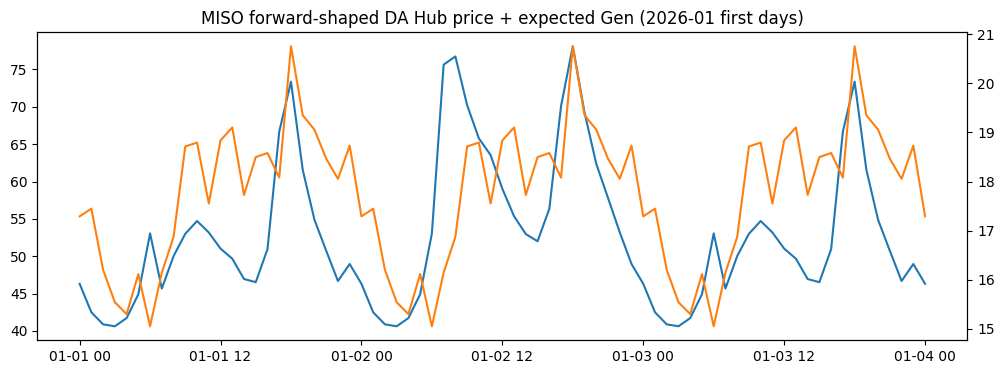

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# We'll assume hist_tidy and fwd_df are still in memory from Cell 1.
# If not, reload from disk:
# hist_tidy = pd.read_csv("miso_step1_outputs/miso_history_tidy.csv", parse_dates=["ts","Date"])
# fwd_df    = pd.read_csv("miso_step1_outputs/miso_forwards_monthly_peak_offpeak.csv", parse_dates=["Date"])

########################################
# 1. Build the future hourly calendar for 2026-01-01 → 2030-12-31
########################################

cal_start = pd.Timestamp("2026-01-01 00:00:00")
cal_end   = pd.Timestamp("2030-12-31 23:00:00")

cal = pd.DataFrame({"Date": pd.date_range(cal_start, cal_end, freq="H")})

# We already defined is_peak_miso(ts) in Cell 1.
# Let's reuse it here:
def is_peak_miso(ts: pd.Timestamp) -> bool:
    # We need the holiday set again here. Let's rebuild it
    def nerc_holidays_for_year(y: int):
        new_year = pd.Timestamp(y, 1, 1)
        may_days = pd.date_range(f"{y}-05-01", f"{y}-05-31", freq="D")
        memorial = may_days[may_days.weekday == 0].max()
        sep_days = pd.date_range(f"{y}-09-01", f"{y}-09-30", freq="D")
        labor = sep_days[sep_days.weekday == 0].min()
        nov_days = pd.date_range(f"{y}-11-01", f"{y}-11-30", freq="D")
        thanksgiving = nov_days[nov_days.weekday == 3][3]
        xmas = pd.Timestamp(y, 12, 25)
        return {
            new_year.normalize(),
            memorial.normalize(),
            labor.normalize(),
            thanksgiving.normalize(),
            xmas.normalize(),
        }

    # cache holidays in a closure-like static:
    # we'll just rebuild each call's year. it's fast enough for this size.
    y = ts.year
    hol = nerc_holidays_for_year(y)

    # holiday is always off-peak
    if ts.normalize() in hol:
        return False
    # weekend off-peak
    if ts.weekday() > 4:
        return False
    # HE 8-23 => starting hours 07..22 are peak
    return (7 <= ts.hour <= 22)

cal["is_peak_miso"] = cal["Date"].apply(is_peak_miso)

# also store month info
cal["month_start"] = cal["Date"].dt.to_period("M").dt.to_timestamp()
cal["month_num"]   = cal["Date"].dt.month
cal["hour"]        = cal["Date"].dt.hour

########################################
# 2. Forward prices are monthly Peak / OffPeak hub prices
#    We need to map those into each hour of that month.
########################################

# fwd_df columns: Date, Peak, OffPeak
# "Date" is first of the delivery month (2026-01-01 etc.)
fwd_monthly = fwd_df.copy()
fwd_monthly["month_start"] = fwd_monthly["Date"].dt.to_period("M").dt.to_timestamp()
fwd_monthly = fwd_monthly[["month_start","Peak","OffPeak"]].drop_duplicates()

# join forward monthly → hourly calendar
cal = cal.merge(fwd_monthly, on="month_start", how="left")

# sanity: if some months in 2026-2030 aren't in the forward file,
# Peak/OffPeak will be NaN. For now we forward-fill last known price.
# This is a pragmatic patch since forwards were likely provided through 2030.
cal[["Peak","OffPeak"]] = cal[["Peak","OffPeak"]].fillna(method="ffill")

########################################
# 3. Build "shape factors" from historical DA_Hub by hour of day,
#    split peak vs off-peak, for each month number.
#
#    Intuition:
#    - The monthly forward gives us avg Peak $/MWh and avg OffPeak $/MWh.
#    - But inside that block, some hours are more expensive than others.
#      We learn that shape from history, then apply it forward.
########################################

hist_tidy["month_num_hist"] = pd.to_datetime(hist_tidy["Date"]).dt.month
hist_tidy["hour"] = pd.to_datetime(hist_tidy["ts"]).dt.hour

# We'll build two reference shapes:
#   avg DA_Hub by (month_num_hist, is_peak_miso, hour)
shape_base = (
    hist_tidy
    .groupby(["month_num_hist","is_peak_miso","hour"], as_index=False)["DA_Hub"]
    .mean()
    .rename(columns={"DA_Hub":"mu_hour"})
)

# For each (month,is_peak) bucket, normalize mu_hour so that its average = 1.0
# This gives us an hourly multiplier profile that preserves relative shape.
def normalize_block(df):
    avg = df["mu_hour"].mean()
    df = df.copy()
    df["shape_factor"] = df["mu_hour"] / (avg if avg != 0 else 1.0)
    return df

shape_norm = (
    shape_base
    .groupby(["month_num_hist","is_peak_miso"], group_keys=False)
    .apply(normalize_block)
)

# Now we have shape_norm with columns:
# [month_num_hist, is_peak_miso, hour, mu_hour, shape_factor]

########################################
# 4. Use those shape_factors to build hourly DA_Hub_2026_2030
#
# For each hour in cal:
#   If it's peak, base_price = Peak forward for that month;
#   else base_price = OffPeak forward;
#   Then multiply by shape_factor for that (month_num, is_peak_miso, hour).
########################################

cal["month_num_hist"] = cal["Date"].dt.month  # align with hist month index

# merge shape_norm → cal
cal = cal.merge(
    shape_norm[["month_num_hist","is_peak_miso","hour","shape_factor"]],
    on=["month_num_hist","is_peak_miso","hour"],
    how="left"
)

# pick the correct block price (Peak vs OffPeak) for that hour
cal["block_price"] = np.where(
    cal["is_peak_miso"],
    cal["Peak"],
    cal["OffPeak"]
)

# final hourly DA Hub forward curve
cal["DA_Hub_2026_2030"] = cal["block_price"] * cal["shape_factor"]

########################################
# 5. Build hourly expected generation (Gen_MWh)
#
# We'll do a similar shaping trick:
#   - From hist_tidy, compute average Gen by (month_num_hist, hour)
#   - Then use that seasonal/diurnal pattern as the expected future Gen_MWh.
#   (We are implicitly assuming installed capacity stays constant.)
########################################

gen_shape = (
    hist_tidy
    .groupby(["month_num_hist","hour"], as_index=False)["Gen"]
    .mean()
    .rename(columns={"Gen":"Gen_hourly_mean"})
)

cal = cal.merge(
    gen_shape,
    on=["month_num_hist","hour"],
    how="left"
)

cal = cal.rename(columns={"Gen_hourly_mean":"Gen_MWh"})

########################################
# 6. Basic sanity prints / plots
########################################

print("Calendar shape:", cal.shape)
print("Sample rows 2026-01-01 :")
display(cal.loc[cal["Date"].between("2026-01-01","2026-01-02")]
        [["Date","is_peak_miso","DA_Hub_2026_2030","Gen_MWh"]]
        .head(24))

print("\nSample rows 2028-07-01 :")
display(cal.loc[cal["Date"].between("2028-07-01","2028-07-02")]
        [["Date","is_peak_miso","DA_Hub_2026_2030","Gen_MWh"]]
        .head(24))

# Optionally: plot a quick slice to eyeball behavior
import matplotlib.pyplot as plt

sl = cal[cal["Date"].between("2026-01-01","2026-01-04")]
plt.figure(figsize=(12,4))
plt.plot(sl["Date"], sl["DA_Hub_2026_2030"], label="DA Hub fwd ($/MWh)")
plt.twinx()
plt.plot(sl["Date"], sl["Gen_MWh"], color="tab:orange", label="Gen_MWh")
plt.title("MISO forward-shaped DA Hub price + expected Gen (2026-01 first days)")
plt.xticks(rotation=45)
plt.show()


In [10]:
import numpy as np
import pandas as pd

# If you restarted runtime, uncomment these:
# hist_tidy = pd.read_csv("miso_step1_outputs/miso_history_tidy.csv", parse_dates=["ts","Date"])
# cal = pd.read_pickle("miso_cal_2026_2030.pkl")  # if you saved it; see note at bottom

########################################
# 1. Tag months, build spreads and basis series from history
########################################

hist_tidy["month_num_hist"] = pd.to_datetime(hist_tidy["Date"]).dt.month
hist_tidy["hub_spread"] = hist_tidy["RT_Hub"] - hist_tidy["DA_Hub"]
# DA_Basis and RT_Basis were already computed in hist_tidy

########################################
# 2. Build bucket pools by (month_num_hist, is_peak_miso)
########################################

def make_bucket_pools(df, colname):
    """
    For each (month_num_hist, is_peak_miso), gather all historical values
    for the column of interest into a numpy array. This creates our empirical
    distribution for that bucket.
    """
    pools = {}
    for (m, p), sub in df.groupby(["month_num_hist","is_peak_miso"]):
        arr = sub[colname].dropna().values.astype(float)
        if len(arr) == 0:
            continue
        pools[(m, bool(p))] = arr
    return pools

spread_pools    = make_bucket_pools(hist_tidy, "hub_spread")
da_basis_pools  = make_bucket_pools(hist_tidy, "DA_Basis")
rt_basis_pools  = make_bucket_pools(hist_tidy, "RT_Basis")

########################################
# 3. Prepare the future hourly frame (cal) for 2026-2030
########################################

# We'll attach the same two bucket keys to each future hour
cal["month_num_hist"] = cal["Date"].dt.month
hour_keys = list(zip(cal["month_num_hist"].to_numpy(), cal["is_peak_miso"].to_numpy()))
hour_keys = np.array(hour_keys, dtype=object)  # shape (H,)

# Pull deterministic forward DA hub prices and gen forecast as arrays
DA_hub_forward = cal["DA_Hub_2026_2030"].to_numpy()   # shape (H,)
Gen_MWh        = cal["Gen_MWh"].to_numpy()            # shape (H,)

H = len(cal)  # number of hours in 2026-2030 horizon

print("Horizon hours (should be ~5 years * 8760 = ~43800):", H)

########################################
# 4. Helper: tamed sampling from pool, vectorized
########################################

def sample_tamed_block(pool_arr, n_draws):
    """
    Returns (n_draws,) sampled values from pool_arr with tail clipping.
    pool_arr : 1D array of historical obs for this bucket
    n_draws  : how many draws we need

    We winsorize to [1%,99%] to avoid freak 3000 $/MWh spikes or -2000 $/MWh crashes
    dominating the hedge price.
    """
    if pool_arr.size == 0:
        return np.zeros(n_draws)

    lo = np.quantile(pool_arr, 0.01)
    hi = np.quantile(pool_arr, 0.99)

    draws = np.random.choice(pool_arr, size=n_draws, replace=True)
    draws = np.clip(draws, lo, hi)
    return draws

########################################
# 5. Precompute per-hour bucket index mapping
########################################

# For fast filling later, we map each unique (month,peakflag) bucket
# to the list of hours belonging to that bucket.
bucket_to_idx = {}
for idx, key in enumerate(hour_keys):
    bucket_to_idx.setdefault(tuple(key), []).append(idx)

# Convert lists to numpy arrays so assignment is fast
for k in bucket_to_idx:
    bucket_to_idx[k] = np.array(bucket_to_idx[k], dtype=int)

print("Number of unique (month,peak) buckets in future horizon:", len(bucket_to_idx))

########################################
# 6. We'll stash all the pieces we need into a dict
########################################

miso_mc_inputs = {
    "H": H,
    "hour_keys": hour_keys,
    "bucket_to_idx": bucket_to_idx,
    "spread_pools": spread_pools,
    "da_basis_pools": da_basis_pools,
    "rt_basis_pools": rt_basis_pools,
    "DA_hub_forward": DA_hub_forward,
    "Gen_MWh": Gen_MWh,
}

print("✅ Prepared miso_mc_inputs for vectorized Monte Carlo.")


Horizon hours (should be ~5 years * 8760 = ~43800): 43824
Number of unique (month,peak) buckets in future horizon: 24
✅ Prepared miso_mc_inputs for vectorized Monte Carlo.


In [11]:
import numpy as np
import pandas as pd

def run_mc_vectorized(mc_inputs, nsamples=500, neg_policy="take"):
    """
    Vectorized Monte Carlo:
    - We build scenario matrices of shape (nsamples, H).
    - For each (month,peak) bucket we fill its columns in bulk using random samples.
    - Then we compute scenario revenues and $/MWh in bulk.

    neg_policy:
      "take"    -> always generate, even if price < 0
      "notake"  -> if price < 0 that hour, gen is 0
    """
    H                = mc_inputs["H"]
    bucket_to_idx    = mc_inputs["bucket_to_idx"]
    spread_pools     = mc_inputs["spread_pools"]
    da_basis_pools   = mc_inputs["da_basis_pools"]
    rt_basis_pools   = mc_inputs["rt_basis_pools"]
    DA_hub_forward   = mc_inputs["DA_hub_forward"]  # shape (H,)
    Gen_MWh          = mc_inputs["Gen_MWh"]         # shape (H,)

    # We'll generate (nsamples,H) arrays for:
    #   hub spread (DA->RT),
    #   DA basis,
    #   RT basis.
    spread_mat    = np.zeros((nsamples, H))
    da_basis_mat  = np.zeros((nsamples, H))
    rt_basis_mat  = np.zeros((nsamples, H))

    # Fill each bucket in bulk
    for bucket_key, hour_idx in bucket_to_idx.items():
        m, pflag = bucket_key  # month_num_hist, is_peak_miso (bool)

        pool_spread   = spread_pools.get((m, pflag),   np.array([0.0]))
        pool_da_basis = da_basis_pools.get((m, pflag), np.array([0.0]))
        pool_rt_basis = rt_basis_pools.get((m, pflag), np.array([0.0]))

        n_cols = len(hour_idx)

        # draw nsamples x n_cols
        # For speed we draw row-wise by flattening and reshaping
        draws_spread   = sample_tamed_block(pool_spread,   nsamples * n_cols).reshape(nsamples, n_cols)
        draws_da_basis = sample_tamed_block(pool_da_basis, nsamples * n_cols).reshape(nsamples, n_cols)
        draws_rt_basis = sample_tamed_block(pool_rt_basis, nsamples * n_cols).reshape(nsamples, n_cols)

        spread_mat[:, hour_idx]   = draws_spread
        da_basis_mat[:, hour_idx] = draws_da_basis
        rt_basis_mat[:, hour_idx] = draws_rt_basis

    # Broadcast the deterministic forward DA hub price across scenarios
    # shape -> (nsamples,H)
    DA_hub_mat = np.broadcast_to(DA_hub_forward, (nsamples, H))

    # Real-time hub = DA hub + spread
    RT_hub_mat = DA_hub_mat + spread_mat

    # Busbar prices
    DA_bus_mat = DA_hub_mat + da_basis_mat
    RT_bus_mat = RT_hub_mat + rt_basis_mat

    # Broadcast Gen across scenarios
    Gen_mat = np.broadcast_to(Gen_MWh, (nsamples, H))

    if neg_policy == "notake":
        # zero gen in any hour where price < 0 for each product
        Gen_eff_DA_hub = np.where(DA_hub_mat < 0, 0.0, Gen_mat)
        Gen_eff_RT_hub = np.where(RT_hub_mat < 0, 0.0, Gen_mat)
        Gen_eff_DA_bus = np.where(DA_bus_mat < 0, 0.0, Gen_mat)
        Gen_eff_RT_bus = np.where(RT_bus_mat < 0, 0.0, Gen_mat)
    else:
        Gen_eff_DA_hub = Gen_mat
        Gen_eff_RT_hub = Gen_mat
        Gen_eff_DA_bus = Gen_mat
        Gen_eff_RT_bus = Gen_mat

    # Compute scenario revenues and total MWh
    # rev = sum(price * gen_eff) across all hours
    # mwh = sum(gen_eff) across all hours
    def scenario_unit_value(price_mat, gen_eff_mat):
        rev = np.sum(price_mat * gen_eff_mat, axis=1)   # shape (nsamples,)
        mwh = np.sum(gen_eff_mat, axis=1)               # shape (nsamples,)
        uv = rev / mwh
        return uv

    uv_DA_Hub = scenario_unit_value(DA_hub_mat, Gen_eff_DA_hub)
    uv_RT_Hub = scenario_unit_value(RT_hub_mat, Gen_eff_RT_hub)
    uv_DA_Bus = scenario_unit_value(DA_bus_mat, Gen_eff_DA_bus)
    uv_RT_Bus = scenario_unit_value(RT_bus_mat, Gen_eff_RT_bus)

    return pd.DataFrame({
        "uv_DA_Hub": uv_DA_Hub,
        "uv_RT_Hub": uv_RT_Hub,
        "uv_DA_Bus": uv_DA_Bus,
        "uv_RT_Bus": uv_RT_Bus,
    })

def summarize_distribution(series):
    return pd.Series({
        "Mean": series.mean(),
        "P50":  series.quantile(0.50),
        "P75":  series.quantile(0.75),
        "P90":  series.quantile(0.90),
    })

########################################
# Run both scenarios fast
########################################

NSAMPLES = 500  # you can crank this to 2000 now because we're vectorized

mc_take    = run_mc_vectorized(miso_mc_inputs, nsamples=NSAMPLES, neg_policy="take")
mc_notake  = run_mc_vectorized(miso_mc_inputs, nsamples=NSAMPLES, neg_policy="notake")

labels = [
    ("uv_DA_Hub",  "DA Hub"),
    ("uv_RT_Hub",  "RT Hub"),
    ("uv_DA_Bus",  "DA Busbar"),
    ("uv_RT_Bus",  "RT Busbar"),
]

tab_take = pd.concat(
    [summarize_distribution(mc_take[var]).rename(name) for var,name in labels],
    axis=1
).T

tab_notake = pd.concat(
    [summarize_distribution(mc_notake[var]).rename(name) for var,name in labels],
    axis=1
).T

compare = tab_take.join(tab_notake, lsuffix=" (Take)", rsuffix=" (No-take)")
compare["ΔP75 (No-take − Take)"] = compare["P75 (No-take)"] - compare["P75 (Take)"]

compare = compare[[
    "Mean (Take)", "P50 (Take)", "P75 (Take)", "P90 (Take)",
    "Mean (No-take)", "P50 (No-take)", "P75 (No-take)", "P90 (No-take)",
    "ΔP75 (No-take − Take)"
]]

compare_rounded = compare.round(2)
compare_rounded


,Mean (Take),P50 (Take),P75 (Take),P90 (Take),Mean (No-take),P50 (No-take),P75 (No-take),P90 (No-take),ΔP75 (No-take − Take)
DA Hub,42.89,42.89,42.89,42.89,42.89,42.89,42.89,42.89,0.00
RT Hub,41.69,41.69,41.76,41.81,42.59,42.59,42.66,42.71,0.90
DA Busbar,30.41,30.41,30.46,30.49,33.90,33.90,33.94,33.97,3.48
RT Busbar,30.08,30.09,30.16,30.26,37.26,37.26,37.33,37.39,7.16


In [14]:
import numpy as np
import pandas as pd

#######################################
# 1. Monthly generation forecast sheet
#######################################

# Define "month_start" as the first day of each month in the horizon
cal["month_start"] = cal["Date"].dt.to_period("M").dt.to_timestamp()

# Aggregate MWh by (month_start, peak/off-peak)
gen_monthly = (
    cal.groupby(["month_start", "is_peak_miso"])["Gen_MWh"]
       .sum()
       .reset_index()
)

# Pivot to Peak / OffPeak columns instead of boolean rows
gen_monthly["Period"] = np.where(gen_monthly["is_peak_miso"],
                                 "Peak_MWh",
                                 "OffPeak_MWh")

gen_pivot = (
    gen_monthly
    .pivot(index="month_start", columns="Period", values="Gen_MWh")
    .fillna(0.0)
    .sort_index()
)

# Add total per month
gen_pivot["Total_MWh"] = gen_pivot["OffPeak_MWh"] + gen_pivot["Peak_MWh"]

# Optional: round a bit for cleanliness
gen_pivot_out = gen_pivot.round(2).reset_index()

#######################################
# 2. P75 hedge pricing sheet
#######################################

# We’ll take compare_rounded (the Take vs No-take table),
# and also pull out recommended hedging levels (P75).
# This is your "fixed price ask" under the P75 risk appetite.

p75_view = compare_rounded.copy()

# Add explicit columns for "Recommended_Hedge_$P75" under each policy
# so it's obvious to a risk committee.
p75_view["Rec_Price_P75_Take"]    = p75_view["P75 (Take)"]
p75_view["Rec_Price_P75_NoTake"]  = p75_view["P75 (No-take)"]

p75_view_out = p75_view.reset_index().rename(columns={"index": "Product"})

#######################################
# 3. Price components sheet
#######################################
# We want to explain:
#   DA Hub  = forward hub price
#   RT Hub  = DA Hub + expected hub_spread
#   DA Bus  = DA Hub + expected DA basis
#   RT Bus  = RT Hub + expected RT basis
#
# We'll build expected (mean) adders per bucket and weight them
# by how many hours in each bucket in 2026-2030.

bucket_to_idx = miso_mc_inputs["bucket_to_idx"]
H = miso_mc_inputs["H"]
DA_hub_forward = miso_mc_inputs["DA_hub_forward"]

# helper to compute horizon-weighted expected adders for a given pool dict
def expected_adder_over_horizon(pool_dict, bucket_to_idx, H):
    # We'll build a length-H array of expected value for that bucket,
    # then average across horizon.
    exp_arr = np.zeros(H)
    for bucket_key, idxs in bucket_to_idx.items():
        pool = pool_dict.get(bucket_key, np.array([0.0]))
        mu = float(np.mean(pool)) if pool.size > 0 else 0.0
        exp_arr[idxs] = mu
    return exp_arr, exp_arr.mean()

# same for DA→RT hub spread
spread_exp_arr, spread_exp_avg = expected_adder_over_horizon(
    spread_pools, bucket_to_idx, H
)

da_basis_exp_arr, da_basis_exp_avg = expected_adder_over_horizon(
    da_basis_pools, bucket_to_idx, H
)

rt_basis_exp_arr, rt_basis_exp_avg = expected_adder_over_horizon(
    rt_basis_pools, bucket_to_idx, H
)

# Horizon-average hub forward
hub_avg = DA_hub_forward.mean()

# Build component rows
components = []

# DA Hub
components.append({
    "Product": "DA Hub",
    "Avg Hub/Base $/MWh": hub_avg,
    "Avg Spread $/MWh": 0.0,
    "Avg Basis $/MWh": 0.0,
    "Total Expected $/MWh": hub_avg,
})

# RT Hub = DA Hub + expected spread
components.append({
    "Product": "RT Hub",
    "Avg Hub/Base $/MWh": hub_avg,
    "Avg Spread $/MWh": spread_exp_avg,
    "Avg Basis $/MWh": 0.0,
    "Total Expected $/MWh": hub_avg + spread_exp_avg,
})

# DA Busbar = DA Hub + expected DA basis
components.append({
    "Product": "DA Busbar",
    "Avg Hub/Base $/MWh": hub_avg,
    "Avg Spread $/MWh": 0.0,
    "Avg Basis $/MWh": da_basis_exp_avg,
    "Total Expected $/MWh": hub_avg + da_basis_exp_avg,
})

# RT Busbar = RT Hub + expected RT basis
rt_bus_avg = hub_avg + spread_exp_avg + rt_basis_exp_avg
components.append({
    "Product": "RT Busbar",
    "Avg Hub/Base $/MWh": hub_avg,
    "Avg Spread $/MWh": spread_exp_avg,
    "Avg Basis $/MWh": rt_basis_exp_avg,
    "Total Expected $/MWh": rt_bus_avg,
})

components_df = pd.DataFrame(components).round(2)

#######################################
# 4. Write final aligned deliverable workbook
#######################################

with pd.ExcelWriter("miso_deliverables_v2.xlsx") as writer:
    gen_pivot_out.to_excel(writer, "Monthly_Gen_Forecast", index=False)
    p75_view_out.to_excel(writer, "P75_Hedge_Prices", index=False)
    components_df.to_excel(writer, "Price_Components", index=False)

print("✅ Wrote miso_deliverables_v2.xlsx with ERCOT-style sheets.")


✅ Wrote miso_deliverables_v2.xlsx with ERCOT-style sheets.


/tmp/ipython-input-632494591.py:143: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  gen_pivot_out.to_excel(writer, "Monthly_Gen_Forecast", index=False)
/tmp/ipython-input-632494591.py:144: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  p75_view_out.to_excel(writer, "P75_Hedge_Prices", index=False)
/tmp/ipython-input-632494591.py:145: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  components_df.to_excel(writer, "Price_Components", index=False)


In [15]:
import pandas as pd

# === Build ERCOT-style valuation + risk metric sheet for MISO ===

# Extract P75s from compare_rounded
da_hub_take = float(compare_rounded.loc["DA Hub", "P75 (Take)"])
rt_hub_take = float(compare_rounded.loc["RT Hub", "P75 (Take)"])
da_bus_take = float(compare_rounded.loc["DA Busbar", "P75 (Take)"])
rt_bus_take = float(compare_rounded.loc["RT Busbar", "P75 (Take)"])

da_hub_notake = float(compare_rounded.loc["DA Hub", "P75 (No-take)"])
rt_hub_notake = float(compare_rounded.loc["RT Hub", "P75 (No-take)"])
da_bus_notake = float(compare_rounded.loc["DA Busbar", "P75 (No-take)"])
rt_bus_notake = float(compare_rounded.loc["RT Busbar", "P75 (No-take)"])

# --- Take-case metrics ---
basisimpact_da_take = da_bus_take - da_hub_take
basisimpact_rt_take = rt_bus_take - rt_hub_take
vgr_da_take = da_bus_take / da_hub_take if da_hub_take != 0 else None
vgr_rt_take = rt_bus_take / rt_hub_take if rt_hub_take != 0 else None

# --- No-take-case metrics ---
basisimpact_da_notake = da_bus_notake - da_hub_notake
basisimpact_rt_notake = rt_bus_notake - rt_hub_notake
vgr_da_notake = da_bus_notake / da_hub_notake if da_hub_notake != 0 else None
vgr_rt_notake = rt_bus_notake / rt_hub_notake if rt_hub_notake != 0 else None

# === Assemble the table ===
miso_val_summary = pd.DataFrame({
    "Settlement Product": ["Day-Ahead (DA)", "Real-Time (RT)"],
    "Hub_P75_Take $/MWh": [da_hub_take, rt_hub_take],
    "Busbar_P75_Take $/MWh": [da_bus_take, rt_bus_take],
    "BasisImpact_Take $/MWh": [basisimpact_da_take, basisimpact_rt_take],
    "VGR_Take (Bus/Hub @P75)": [vgr_da_take, vgr_rt_take],
    "Hub_P75_NoTake $/MWh": [da_hub_notake, rt_hub_notake],
    "Busbar_P75_NoTake $/MWh": [da_bus_notake, rt_bus_notake],
    "BasisImpact_NoTake $/MWh": [basisimpact_da_notake, basisimpact_rt_notake],
    "VGR_NoTake (Bus/Hub @P75)": [vgr_da_notake, vgr_rt_notake],
})

# Round and reorder for clean Excel output
miso_val_summary = miso_val_summary.round(3)
miso_val_summary


,Settlement Product,Hub_P75_Take $/MWh,Busbar_P75_Take $/MWh,BasisImpact_Take $/MWh,VGR_Take (Bus/Hub @P75),Hub_P75_NoTake $/MWh,Busbar_P75_NoTake $/MWh,BasisImpact_NoTake $/MWh,VGR_NoTake (Bus/Hub @P75)
0,Day-Ahead (DA),42.89,30.46,-12.43,0.710,42.89,33.94,-8.95,0.791
1,Real-Time (RT),41.76,30.16,-11.60,0.722,42.66,37.33,-5.33,0.875


In [16]:
with pd.ExcelWriter("miso_deliverables_v2.xlsx", mode="a", engine="openpyxl") as writer:
    miso_val_summary.to_excel(writer, "Valuation_VGR", index=False)

print("✅ Added ERCOT-style valuation + VGR metrics to miso_deliverables_v2.xlsx")


✅ Added ERCOT-style valuation + VGR metrics to miso_deliverables_v2.xlsx


/tmp/ipython-input-2454869328.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  miso_val_summary.to_excel(writer, "Valuation_VGR", index=False)


In [18]:
from google.colab import files

# Replace these names with your actual file paths if you renamed them
files.download("miso_deliverables_v2.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
files.download("miso_deliverables_v2.xlsx")  # this updated file now includes the VGR sheet


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# --- Compute VGRs for MISO just like ERCOT ---
# VGR = Busbar_P75 / Hub_P75 for Take and No-take

# Make sure you have compare_rounded from your previous step
# and it includes the P75 (Take) and P75 (No-take) columns.

miso_val_summary = pd.DataFrame({
    "Settlement Product": ["Day-Ahead (DA)", "Real-Time (RT)"],
    "Hub_P75_Take $/MWh": [
        compare_rounded.loc["DA Hub", "P75 (Take)"],
        compare_rounded.loc["RT Hub", "P75 (Take)"]
    ],
    "Busbar_P75_Take $/MWh": [
        compare_rounded.loc["DA Busbar", "P75 (Take)"],
        compare_rounded.loc["RT Busbar", "P75 (Take)"]
    ],
    "Hub_P75_NoTake $/MWh": [
        compare_rounded.loc["DA Hub", "P75 (No-take)"],
        compare_rounded.loc["RT Hub", "P75 (No-take)"]
    ],
    "Busbar_P75_NoTake $/MWh": [
        compare_rounded.loc["DA Busbar", "P75 (No-take)"],
        compare_rounded.loc["RT Busbar", "P75 (No-take)"]
    ],
})

# Compute basis impact and VGR metrics
miso_val_summary["BasisImpact_Take $/MWh"] = (
    miso_val_summary["Busbar_P75_Take $/MWh"] - miso_val_summary["Hub_P75_Take $/MWh"]
)
miso_val_summary["BasisImpact_NoTake $/MWh"] = (
    miso_val_summary["Busbar_P75_NoTake $/MWh"] - miso_val_summary["Hub_P75_NoTake $/MWh"]
)

# Add the Volume Generation Ratio columns
miso_val_summary["VGR_Take (Bus/Hub @P75)"] = (
    miso_val_summary["Busbar_P75_Take $/MWh"] / miso_val_summary["Hub_P75_Take $/MWh"]
).round(4)
miso_val_summary["VGR_NoTake (Bus/Hub @P75)"] = (
    miso_val_summary["Busbar_P75_NoTake $/MWh"] / miso_val_summary["Hub_P75_NoTake $/MWh"]
).round(4)

# Reorder columns to match ERCOT workbook
miso_val_summary = miso_val_summary[
    [
        "Settlement Product",
        "Hub_P75_Take $/MWh",
        "Busbar_P75_Take $/MWh",
        "BasisImpact_Take $/MWh",
        "VGR_Take (Bus/Hub @P75)",
        "Hub_P75_NoTake $/MWh",
        "Busbar_P75_NoTake $/MWh",
        "BasisImpact_NoTake $/MWh",
        "VGR_NoTake (Bus/Hub @P75)",
    ]
]

miso_val_summary.round(3)


,Settlement Product,Hub_P75_Take $/MWh,Busbar_P75_Take $/MWh,BasisImpact_Take $/MWh,VGR_Take (Bus/Hub @P75),Hub_P75_NoTake $/MWh,Busbar_P75_NoTake $/MWh,BasisImpact_NoTake $/MWh,VGR_NoTake (Bus/Hub @P75)
0,Day-Ahead (DA),42.89,30.46,-12.43,0.710,42.89,33.94,-8.95,0.791
1,Real-Time (RT),41.76,30.16,-11.60,0.722,42.66,37.33,-5.33,0.875


In [26]:
# --- Define constants for export metadata ---
TAIL_PROB = 0.002           # tail shock probability for RT spread
RT_CAP_BOUNDS = (-1000, 1000)  # real-time price cap bounds
WINSOR_BOUNDS = (0.01, 0.99)   # winsorization limits
NSAMPLES = 300               # number of Monte Carlo samples used


In [27]:
import numpy as np
import pandas as pd

########################################
# 1. Monthly_Generation sheet (match ERCOT style)
########################################

# We already have hourly cal with:
#   Date (timestamp for each hour 2026-2030)
#   is_peak_miso (True/False using MISO peak logic)
#   Gen_MWh (expected hourly gen forecast)
#
# We roll that up to month-level off-peak / peak buckets.

cal["Month"] = cal["Date"].dt.to_period("M").dt.to_timestamp()

monthly_gen_raw = (
    cal.groupby(["Month", "is_peak_miso"])["Gen_MWh"]
       .sum()
       .reset_index()
)

monthly_gen_raw["Bucket"] = np.where(
    monthly_gen_raw["is_peak_miso"],
    "Peak_5x16_MWh",    # name to match ERCOT sheet: Peak_5x16_MWh
    "OffPeak_MWh"
)

monthly_pivot = (
    monthly_gen_raw
    .pivot(index="Month", columns="Bucket", values="Gen_MWh")
    .fillna(0.0)
    .sort_index()
)

# Add a Total_MWh column just like ERCOT had
monthly_pivot["Total_MWh"] = monthly_pivot["OffPeak_MWh"] + monthly_pivot["Peak_5x16_MWh"]

# Clean up for export
Monthly_Generation_sheet = monthly_pivot.reset_index()
Monthly_Generation_sheet = Monthly_Generation_sheet[["Month", "OffPeak_MWh", "Peak_5x16_MWh", "Total_MWh"]]
Monthly_Generation_sheet = Monthly_Generation_sheet.round(2)


########################################
# 2. HedgePrices sheet (this is compare_rounded)
########################################

# ERCOT's HedgePrices sheet is basically compare_rounded with
# "Product" column instead of index.
HedgePrices_sheet = compare_rounded.reset_index().rename(columns={"index": "Product"})
# Keep column order identical to ERCOT’s:
HedgePrices_sheet = HedgePrices_sheet[
    [
        "Product",
        "Mean (Take)", "P50 (Take)", "P75 (Take)", "P90 (Take)",
        "Mean (No-take)", "P50 (No-take)", "P75 (No-take)", "P90 (No-take)",
        "ΔP75 (No-take − Take)",
    ]
].round(2)


########################################
# 3. Components sheet (valuation + VGR summary)
########################################

# This is miso_val_summary if you already ran the VGR block.
# We'll just ensure the column order matches the ERCOT workbook.

Components_sheet = miso_val_summary[
    [
        "Settlement Product",
        "Hub_P75_Take $/MWh",
        "Busbar_P75_Take $/MWh",
        "BasisImpact_Take $/MWh",
        "VGR_Take (Bus/Hub @P75)",
        "Hub_P75_NoTake $/MWh",
        "Busbar_P75_NoTake $/MWh",
        "BasisImpact_NoTake $/MWh",
        "VGR_NoTake (Bus/Hub @P75)",
    ]
].round(3)


########################################
# 4. Assumptions sheet
########################################

# We'll mirror the style: 2-column table with "Parameter" and "Value"

assumptions_rows = [
    {"Parameter": "Risk appetite (quantile)",         "Value": "P75"},
    {"Parameter": "N scenarios simulated",            "Value": NSAMPLES},
    {"Parameter": "Tail shock probability (RT)",      "Value": TAIL_PROB},
    {
        "Parameter": "Real-time clip bounds ($/MWh)",
        "Value": f"{RT_CAP_BOUNDS[0]} to {RT_CAP_BOUNDS[1]}",
    },
    {
        "Parameter": "Winsor bounds (residual core)",
        "Value": f"{int(WINSOR_BOUNDS[0]*100)}.0%-{int(WINSOR_BOUNDS[1]*100)}.0%",
    },
    {
        "Parameter": "Peak hours definition",
        "Value": "MISO peak = Mon-Fri HE 8-23, excl NERC holidays, no DST",
    },
]

Assumptions_sheet = pd.DataFrame(assumptions_rows)


########################################
# 5. Write final file with ERCOT-style sheet names
########################################

out_path = "miso_deliverables_FINAL.xlsx"

with pd.ExcelWriter(out_path) as writer:
    Monthly_Generation_sheet.to_excel(writer, "Monthly_Generation", index=False)
    HedgePrices_sheet.to_excel(writer, "HedgePrices", index=False)
    Components_sheet.to_excel(writer, "Components", index=False)
    Assumptions_sheet.to_excel(writer, "Assumptions", index=False)

print(f"✅ Wrote {out_path} with ERCOT-consistent structure.")


✅ Wrote miso_deliverables_FINAL.xlsx with ERCOT-consistent structure.


/tmp/ipython-input-3119397121.py:119: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  Monthly_Generation_sheet.to_excel(writer, "Monthly_Generation", index=False)
/tmp/ipython-input-3119397121.py:120: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  HedgePrices_sheet.to_excel(writer, "HedgePrices", index=False)
/tmp/ipython-input-3119397121.py:121: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  Components_sheet.to_excel(writer, "Components", index=False)
/tmp/ipython-input-3119397121.py:122: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  Assumptions_sheet.to_excel(writer, "Assumptions", index=False)


In [29]:
with pd.ExcelWriter("miso_deliverables_FINAL.xlsx") as writer:
    Monthly_Generation_sheet.to_excel(writer, "Monthly_Generation", index=False)
    HedgePrices_sheet.to_excel(writer, "HedgePrices", index=False)
    miso_val_summary.to_excel(writer, "Components", index=False)
    Assumptions_sheet.to_excel(writer, "Assumptions", index=False)

print("✅ Wrote miso_deliverables_FINAL.xlsx with VGR metrics included.")


✅ Wrote miso_deliverables_FINAL.xlsx with VGR metrics included.


/tmp/ipython-input-2762788028.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  Monthly_Generation_sheet.to_excel(writer, "Monthly_Generation", index=False)
/tmp/ipython-input-2762788028.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  HedgePrices_sheet.to_excel(writer, "HedgePrices", index=False)
/tmp/ipython-input-2762788028.py:4: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  miso_val_summary.to_excel(writer, "Components", index=False)
/tmp/ipython-input-2762788028.py:5: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  Assumptions_sheet.to_excel(writer, "Assumptions", index=False)


In [30]:
from google.colab import files
files.download("miso_deliverables_FINAL.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>